In [2]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import json
from tqdm import tqdm
import yaml

#import geopandas as gpd
import pandas as pd

import torch

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt
import utils.processing as proc
import utils.eval_pipe as eval

import utils.model_loader as md
import utils.data_loader as dt
import utils.config_loader as cf

%load_ext autoreload
%autoreload 2


In [3]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[1:8]  # Select the first 6 experiment names

global_config = md.global_config


## most recents

In [69]:
run_id_base = "251021_GEN_"
# run_id_base = "251024_GEN2_"
# run_id_base = "251025_GEN_"
repetitions = 5
combos = ["110","101","011"] #1 is training data, 0 test.
run_ids = []
for i in range(repetitions): # Run 10 experiments with different seeds
    for combo in combos:
        #run_id = md.generate_run_id()
        run_id = run_id_base + f"_{combo}_{i}"
        run_ids.append(run_id)

#run_ids = ["251021_GEN__"]

In [70]:
run_ids

['251021_GEN__110_0',
 '251021_GEN__101_0',
 '251021_GEN__011_0',
 '251021_GEN__110_1',
 '251021_GEN__101_1',
 '251021_GEN__011_1',
 '251021_GEN__110_2',
 '251021_GEN__101_2',
 '251021_GEN__011_2',
 '251021_GEN__110_3',
 '251021_GEN__101_3',
 '251021_GEN__011_3',
 '251021_GEN__110_4',
 '251021_GEN__101_4',
 '251021_GEN__011_4']

In [71]:
# SELECT EXPERIMENTAL CONFIG
for run_id in tqdm(run_ids):
    with open('../configs/experiments.yaml', 'r') as f:
        experiments = yaml.safe_load(f)
        # experiment_names = list(experiments.keys())
        #run_id = "251009_4" #"250929_02" #"250930_1"
        exp_dir = os.path.join("..", "results", run_id, "train")
        if not os.path.exists(exp_dir):
            print(f"Experiment directory does not exist for run_id {run_id}. Skipping...")
            continue

        experiment_names = sorted(
            [name for name in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, name))]
        )
        print("Available experiments:", experiment_names)

    df_result = pd.DataFrame()
    for exp_name in experiment_names:
        sites, cfg = cf.get_config(exp_name)
        #global_config = md.global_config
        model_weights, logs, cfg = md.load_results(exp_name, run_id)
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = [None] * 7
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = md.load_np_stacks(exp_name, run_id)
        report = eval.ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test)
        df_result = eval.write_metrics_to_df(report, sites, cfg, df=df_result)
        
        # print("===========================")
        # print("EVAL REPORT FOR EXPERIMENT: ", exp_name)
        #eval.print_all_metrics(report, sites, cfg, above2m=True)
        #eval.plot_error_over_frequency(report, bins=80, title = f"{exp_name} - Error vs. GT Distribution")
        eval.printout_eval_report(report, sites, cfg, run_id)
        #print("====================================")

        # Print the evaluation report
    #print(df_result.transpose().to_string())
    eval.save_df_result_to_csv(df_result, run_id, override=True)


  0%|          | 0/15 [00:00<?, ?it/s]

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


  7%|▋         | 1/15 [00:03<00:47,  3.39s/it]

Results saved to ../results/251021_GEN__110_0/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 13%|█▎        | 2/15 [00:06<00:41,  3.19s/it]

Results saved to ../results/251021_GEN__101_0/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 20%|██        | 3/15 [00:09<00:38,  3.21s/it]

Results saved to ../results/251021_GEN__011_0/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 27%|██▋       | 4/15 [00:12<00:34,  3.18s/it]

Results saved to ../results/251021_GEN__110_1/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 33%|███▎      | 5/15 [00:15<00:31,  3.12s/it]

Results saved to ../results/251021_GEN__101_1/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 40%|████      | 6/15 [00:19<00:28,  3.18s/it]

Results saved to ../results/251021_GEN__011_1/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 47%|████▋     | 7/15 [00:22<00:24,  3.10s/it]

Results saved to ../results/251021_GEN__110_2/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 53%|█████▎    | 8/15 [00:25<00:22,  3.16s/it]

Results saved to ../results/251021_GEN__101_2/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 60%|██████    | 9/15 [00:28<00:18,  3.15s/it]

Results saved to ../results/251021_GEN__011_2/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 67%|██████▋   | 10/15 [00:31<00:15,  3.17s/it]

Results saved to ../results/251021_GEN__110_3/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 73%|███████▎  | 11/15 [00:34<00:12,  3.10s/it]

Results saved to ../results/251021_GEN__101_3/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 80%|████████  | 12/15 [00:37<00:09,  3.13s/it]

Results saved to ../results/251021_GEN__011_3/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 87%|████████▋ | 13/15 [00:41<00:06,  3.32s/it]

Results saved to ../results/251021_GEN__110_4/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 93%|█████████▎| 14/15 [00:44<00:03,  3.23s/it]

Results saved to ../results/251021_GEN__101_4/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


100%|██████████| 15/15 [00:47<00:00,  3.18s/it]

Results saved to ../results/251021_GEN__011_4/metrics/results_summary.csv


In [186]:
df_big = eval.read_multiple_csv_to_df(run_ids)

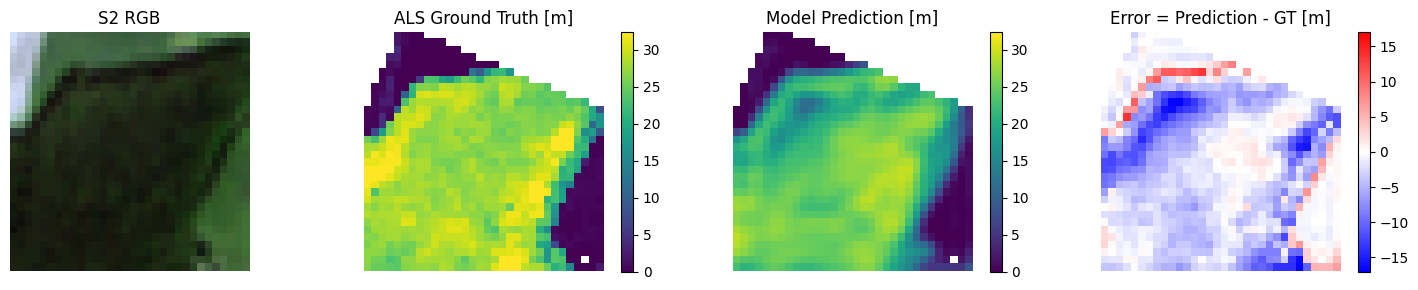

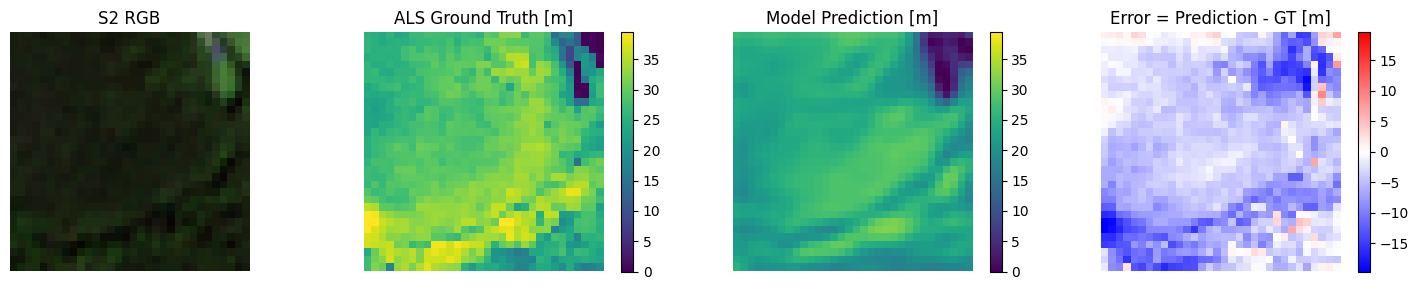

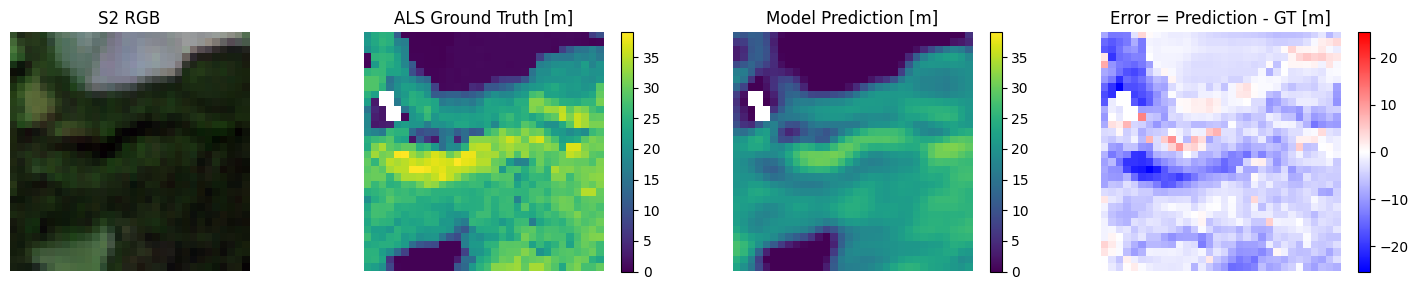

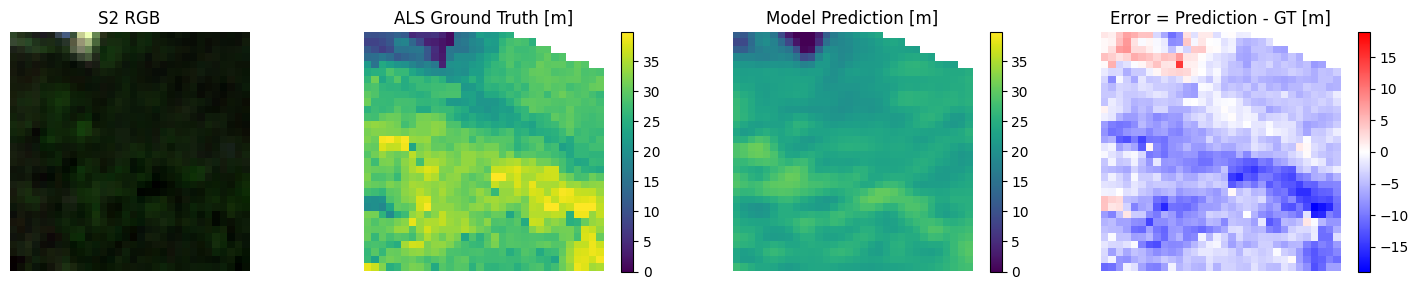

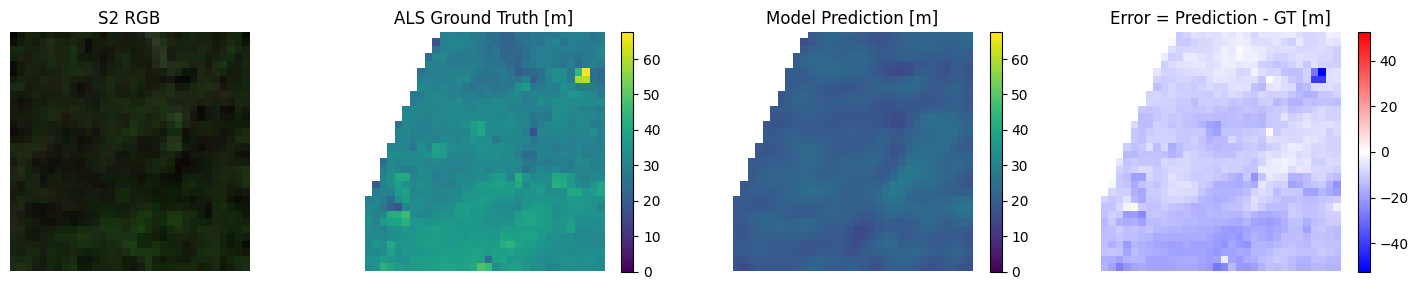

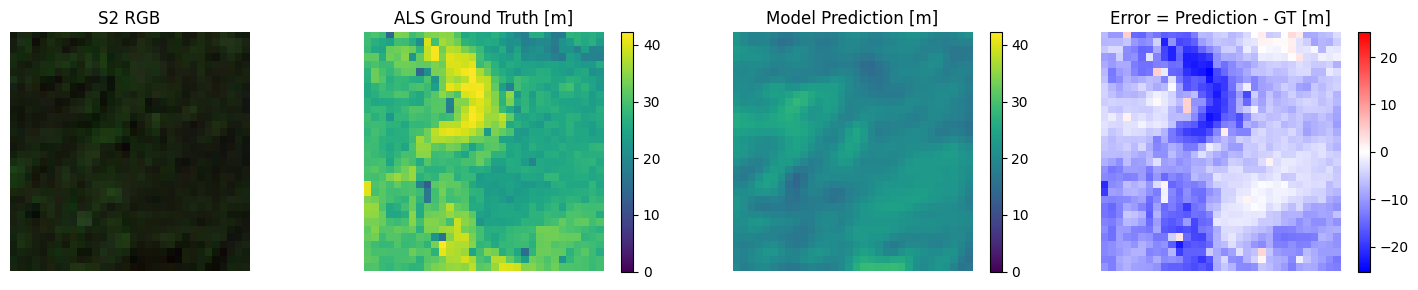

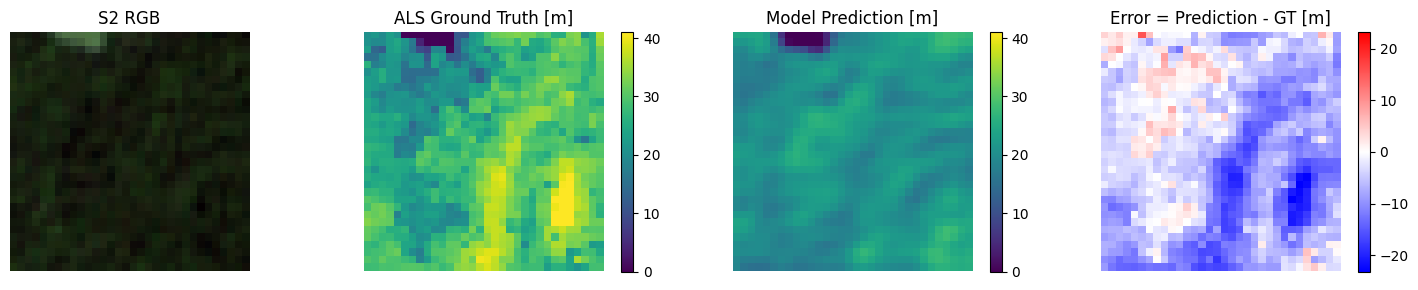

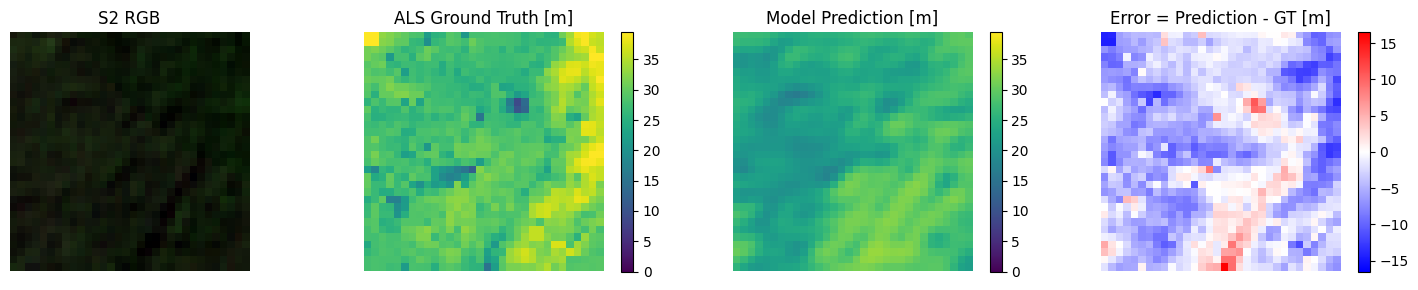

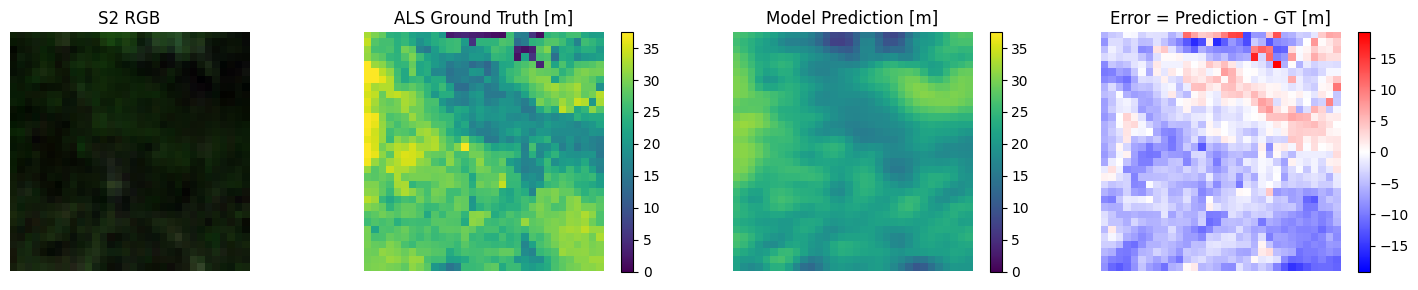

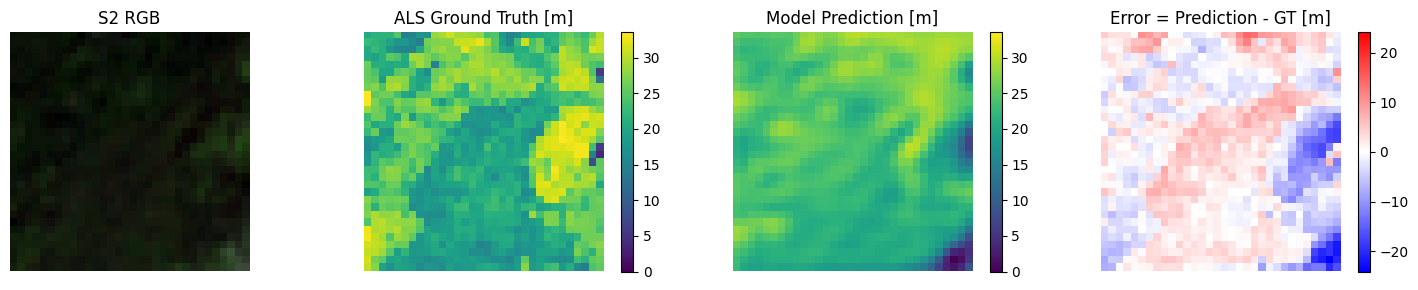

In [311]:
eval.plot_real_pred_delta(report, num_samples=10)

## plot metrics

### data prepped

In [72]:
run_id_base = "251021_GEN_"
repetitions = 5
combos = ["110","101","011"] #1 is training data, 0 test.
run_ids = []
for i in range(repetitions): # Run 10 experiments with different seeds
    for combo in combos:
        #run_id = md.generate_run_id()
        run_id = run_id_base + f"_{combo}_{i}"
        run_ids.append(run_id)

target_folder = "gen/final"
stats, readablestats = eval.save_big_df_stats(run_ids=run_ids, target_folder=target_folder)

Generalization results saved to ../results/gen/final/metrics/results_summary.csv


In [3]:
# get the all-in stats
#run_ids = ["251024_FINAL_" + str(i) for i in range(5)]
run_ids = ["251102_ALLIN_" + str(i) for i in range(5)]
target_folder = "all_in/final"
stats, readablestats = eval.save_big_df_stats(run_ids=run_ids, target_folder=target_folder)

Generalization results saved to ../results/all_in/final/metrics/results_summary.csv


From here on sitewise all in reference

In [4]:
gen_path = "../results/gen/final/metrics/results_summary.csv"
#allin_path = "../results/all_in/test1/metrics/results_summary.csv"
allin_path = "../results/all_in/final/metrics/results_summary.csv"

gen_df = pd.read_csv(gen_path) # only column combo as dtype categorical
allin_df = pd.read_csv(allin_path)

master_df = pd.concat([gen_df, allin_df], ignore_index=True)
master_df = master_df.melt(id_vars=["Experiment", "combo"], 
                           var_name="Metrics", 
                           value_name="Value")

In [5]:
gen_path = "../results/gen/final/metrics/results_summary.csv"
gen_df = pd.read_csv(gen_path) # only column combo as dtype categorical

sitewisepath = "../results/all_in/final/metrics/sitewise_metrics_summary.csv"
sitewise_df = pd.read_csv(sitewisepath)

In [6]:
# Initialize sitewisemaster_df
sitewisemaster_df = pd.DataFrame()

# Mapping between combo and site_id
combo_sites = {
    "_011": 0,  # Ebrach
    "_101": 1,  # Waldbrunn
    "_110": 2   # Berchtesgaden
}

def genscore(metric_gen, metric_allin):
    gscore = (1 - abs(metric_gen - metric_allin) / metric_allin) * 100  # percent
    return gscore

def std_prop(std_gen, std_allin):
    sprop = std_gen / std_allin
    return sprop

metrics = ['MAE [m] (Test)', 'nMAE [%] (Test)', 'RMSE [m] (Test)','Bias [m] (Test)', 'R2 [-] (Test)', 'F1 FMASK (Test)', "F1 DLT (Test)"]

# For each row in gen_df
for _, gen_row in gen_df.iterrows():
    experiment = gen_row['Experiment']
    combo = gen_row['combo']
    site_id = combo_sites[combo]
    
    # For each metric
    for metric in metrics:
        # Get the value from gen_df (column name format: "METRIC Mean")
        gen_value = gen_row[f'{metric} Mean']
        gen_std = gen_row[f'{metric} Std']
        
        # Find corresponding row in sitewise_df (all-in data)
        allin_row = sitewise_df[
            (sitewise_df['experiment'] == experiment) & 
            (sitewise_df['site_id'] == site_id) & 
            (sitewise_df['metric'] == metric)
        ]
        
        allin_mean = allin_row['mean'].values[0] if len(allin_row) > 0 else np.nan
        allin_std = allin_row['std'].values[0] if len(allin_row) > 0 else np.nan
        
        new_row = {
            "Experiment": experiment,
            "combo": combo,
            "Metrics": metric,
            "Gen_Mean": gen_value,
            "Gen_Std": gen_std,
            "Allin_Mean": allin_mean,
            "Allin_Std": allin_std,
            "Gen_Score": genscore(gen_value, allin_mean) if not np.isnan(allin_mean) else np.nan,
            "Std_Proportion": std_prop(gen_std, allin_std) if not np.isnan(allin_std) else np.nan
        }
        sitewisemaster_df = pd.concat([sitewisemaster_df, pd.DataFrame([new_row])], ignore_index=True)


In [7]:
sitewisemaster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Experiment      147 non-null    object 
 1   combo           147 non-null    object 
 2   Metrics         147 non-null    object 
 3   Gen_Mean        111 non-null    float64
 4   Gen_Std         111 non-null    float64
 5   Allin_Mean      111 non-null    float64
 6   Allin_Std       111 non-null    float64
 7   Gen_Score       111 non-null    float64
 8   Std_Proportion  111 non-null    float64
dtypes: float64(6), object(3)
memory usage: 10.5+ KB


../results/gen/finalsitewise/gscore/


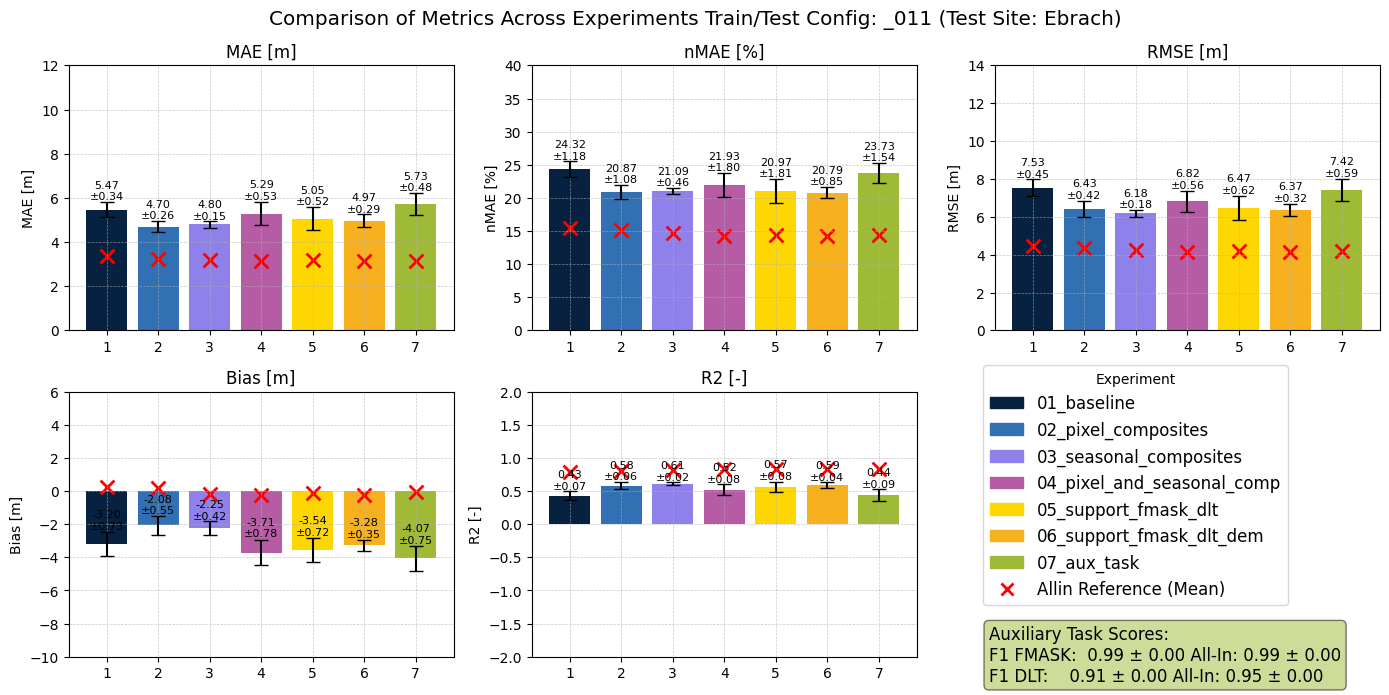

../results/gen/finalsitewise/gscore/


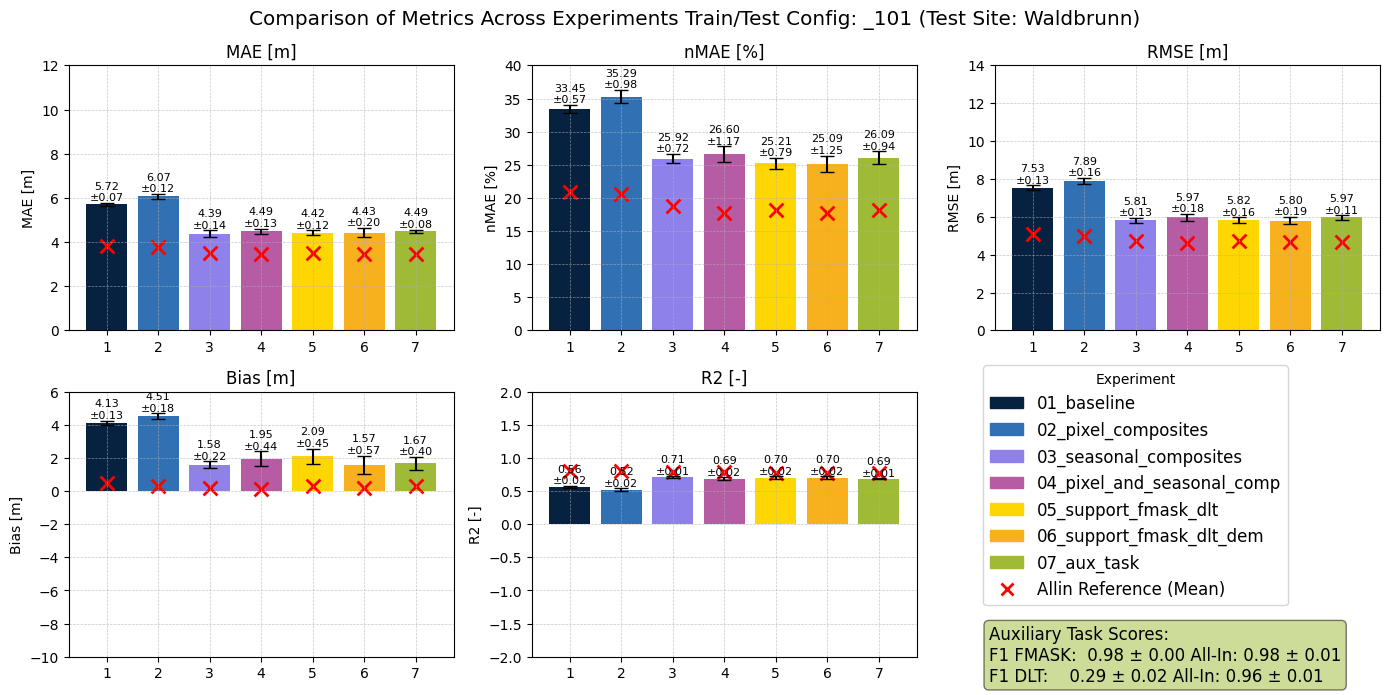

../results/gen/finalsitewise/gscore/


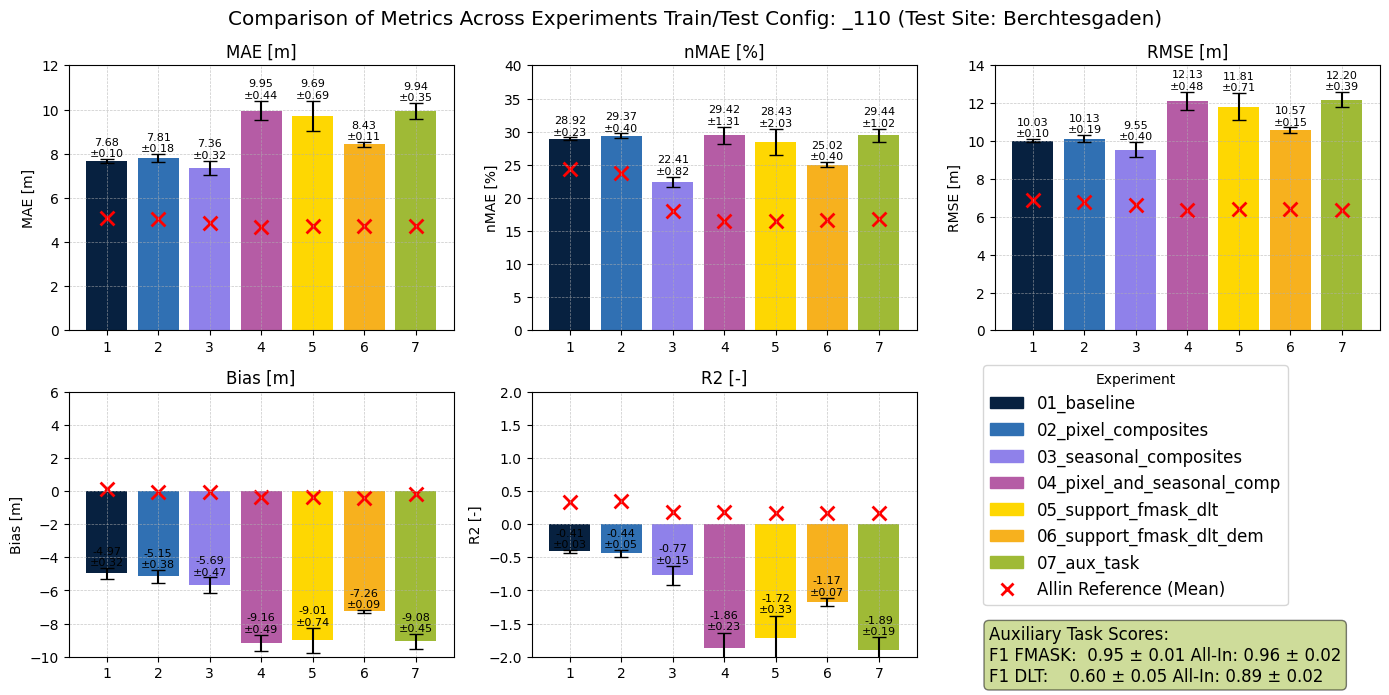

In [8]:
fig = eval.plot_comparison_all_gen_sitespec(sitewisemaster_df, targetfolder="finalsitewise",printout=True, savefig=True)

### metrics plotted

In [10]:
dfgs = eval.generalization_checker_sitespec(gen_path=gen_path,allin_path=sitewisepath)
dfgs = dfgs[dfgs["Score_Type"]=="mean_score"]

/Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/src/../utils/eval_pipe.py:1226: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  genscore_df = pd.concat([genscore_df, pd.DataFrame([{


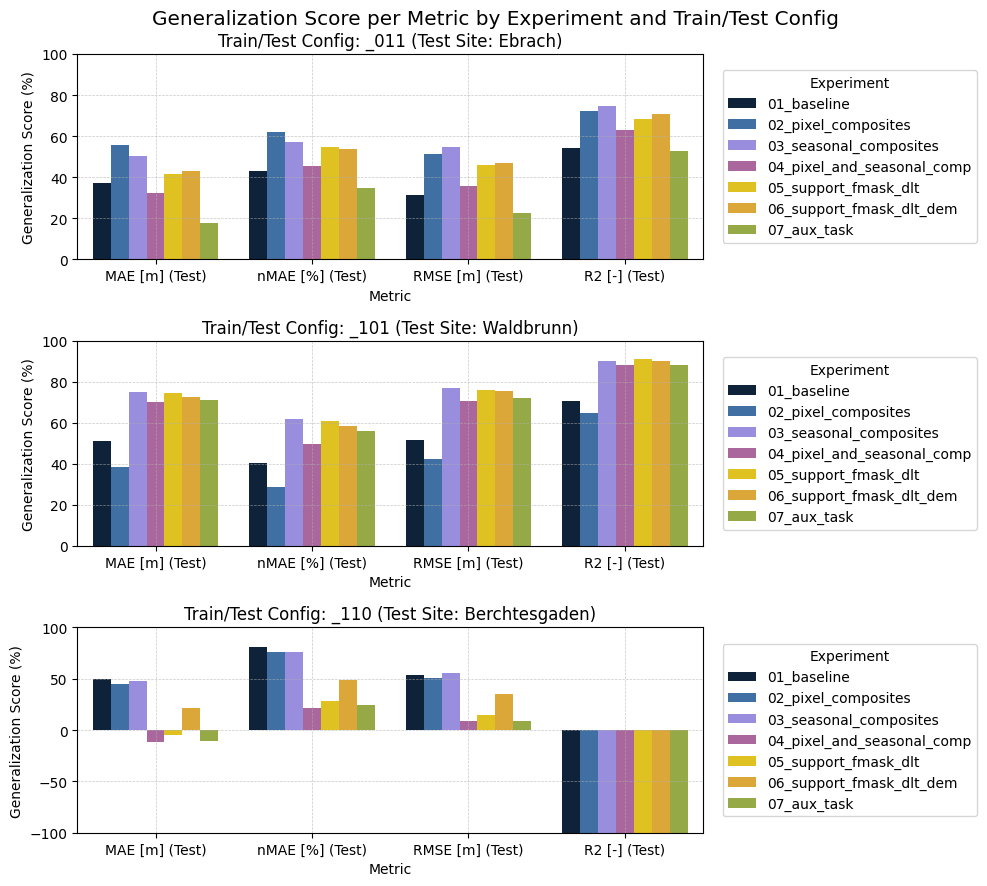

Generalization score plot saved to ../results/gen/finalsitewise/gscore/genscore.png


In [15]:
fig = eval.plot_genscore(dfgs, printout=True, targetfolder="finalsitewise", savefig=True)

../results/gen/final/gscore/


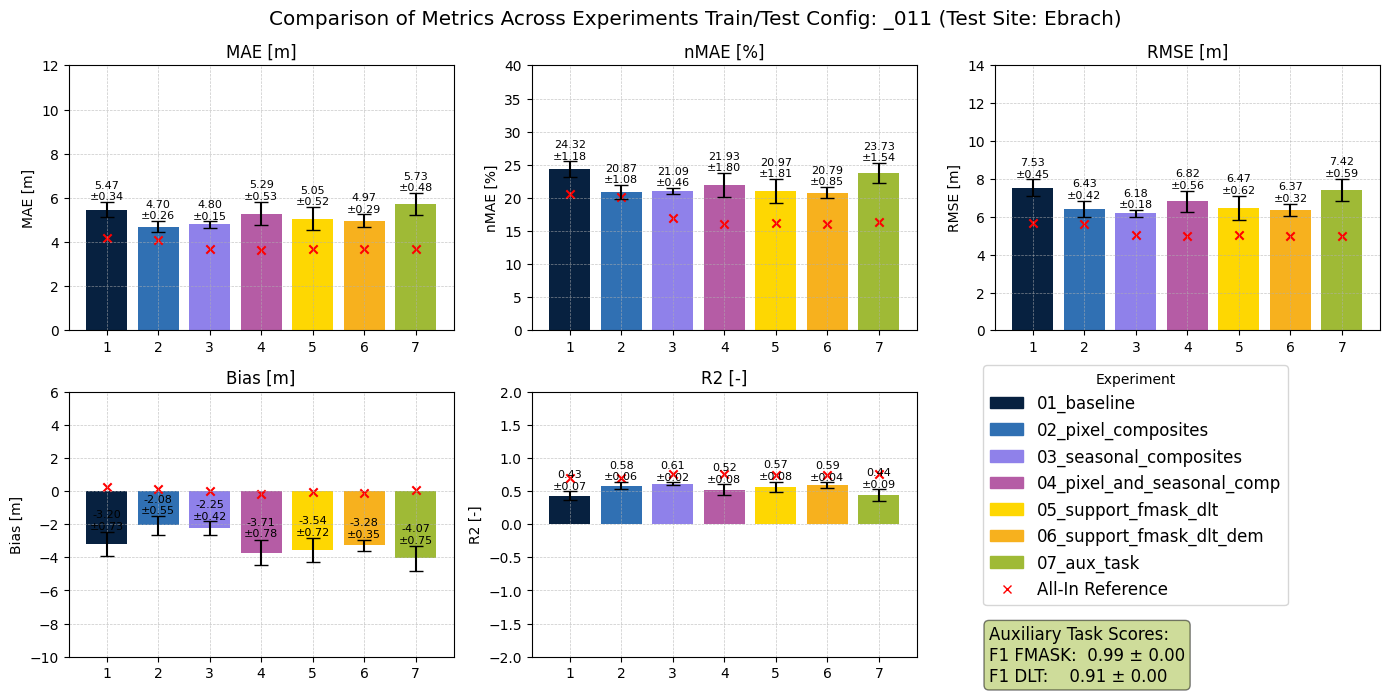

../results/gen/final/gscore/


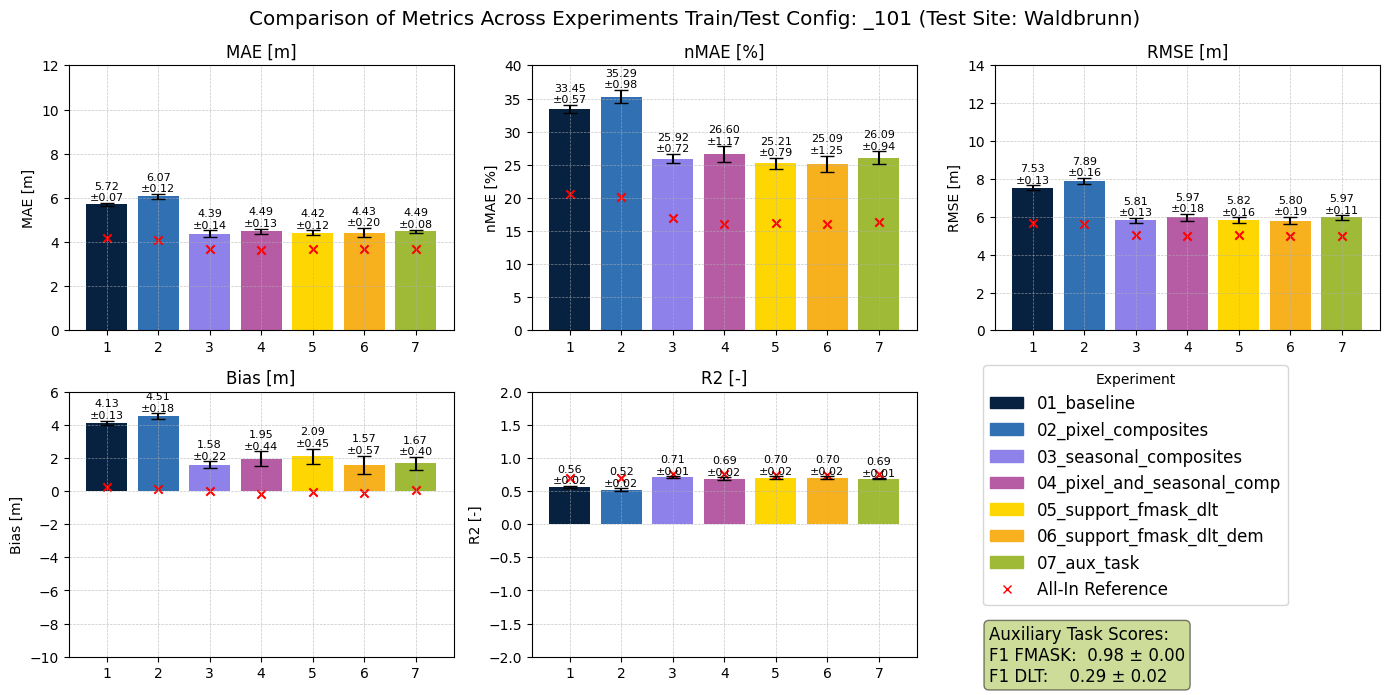

../results/gen/final/gscore/


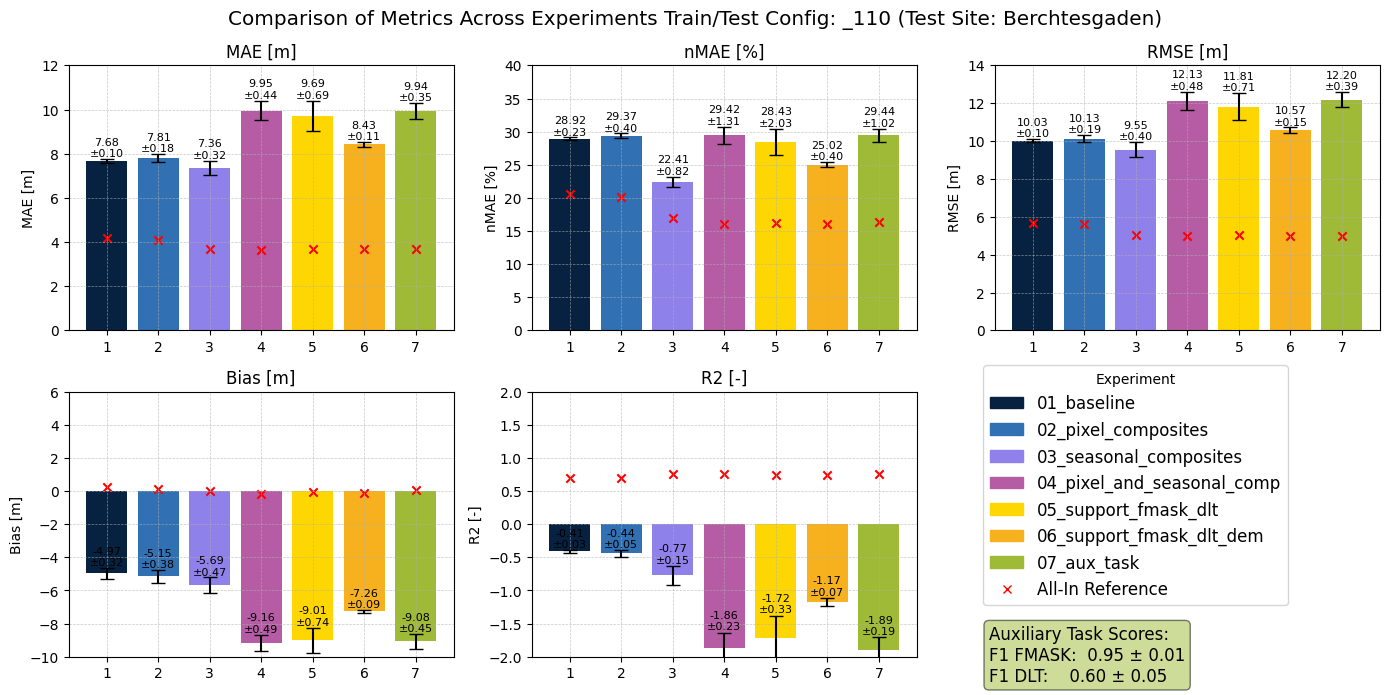

In [12]:
fig = eval.plot_comparison_all_gen(master_df, targetfolder="final",printout=True, savefig=True)

### old one

In [190]:
dfgs = eval.generalization_checker(gen_path=gen_path,allin_path=allin_path)
dfgs = dfgs[dfgs["Score_Type"]=="mean_score"]

/Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/src/../utils/eval_pipe.py:1030: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  genscore_df = pd.concat([genscore_df, pd.DataFrame([{


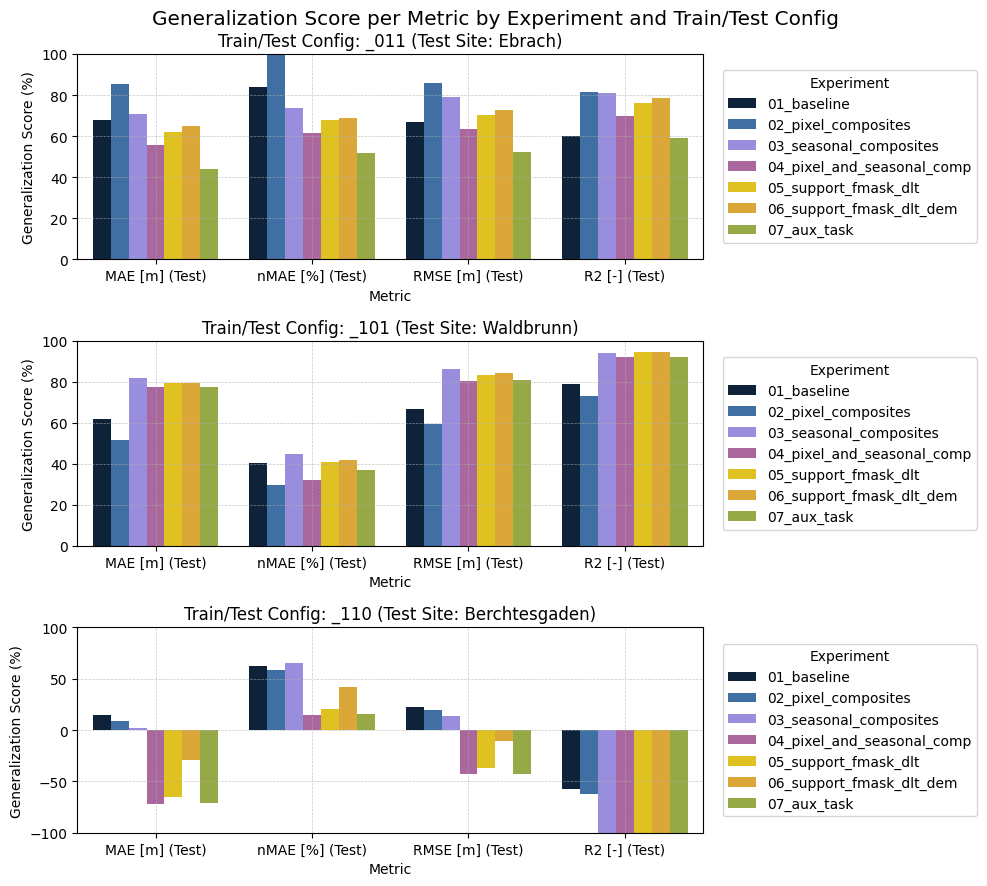

In [191]:
fig = eval.plot_genscore(dfgs, printout=True, targetfolder="final")

In [167]:
master_df["combo"].unique()

array(['_011', '_101', '_110', '_allin'], dtype=object)

In [195]:
master_df

,Experiment,combo,Metrics,Value
0,01_baseline,_011,MAE [m] (Test) Mean,5.472
1,01_baseline,_101,MAE [m] (Test) Mean,5.718
2,01_baseline,_110,MAE [m] (Test) Mean,7.680
3,02_pixel_composites,_011,MAE [m] (Test) Mean,4.698
4,02_pixel_composites,_101,MAE [m] (Test) Mean,6.070
...,...,...,...,...
583,03_seasonal_composites,_allin,F1 DLT (Test) Count,0.000
584,04_pixel_and_seasonal_comp,_allin,F1 DLT (Test) Count,0.000
585,05_support_fmask_dlt,_allin,F1 DLT (Test) Count,0.000
586,06_support_fmask_dlt_dem,_allin,F1 DLT (Test) Count,0.000


../results/gen/final/gscore/


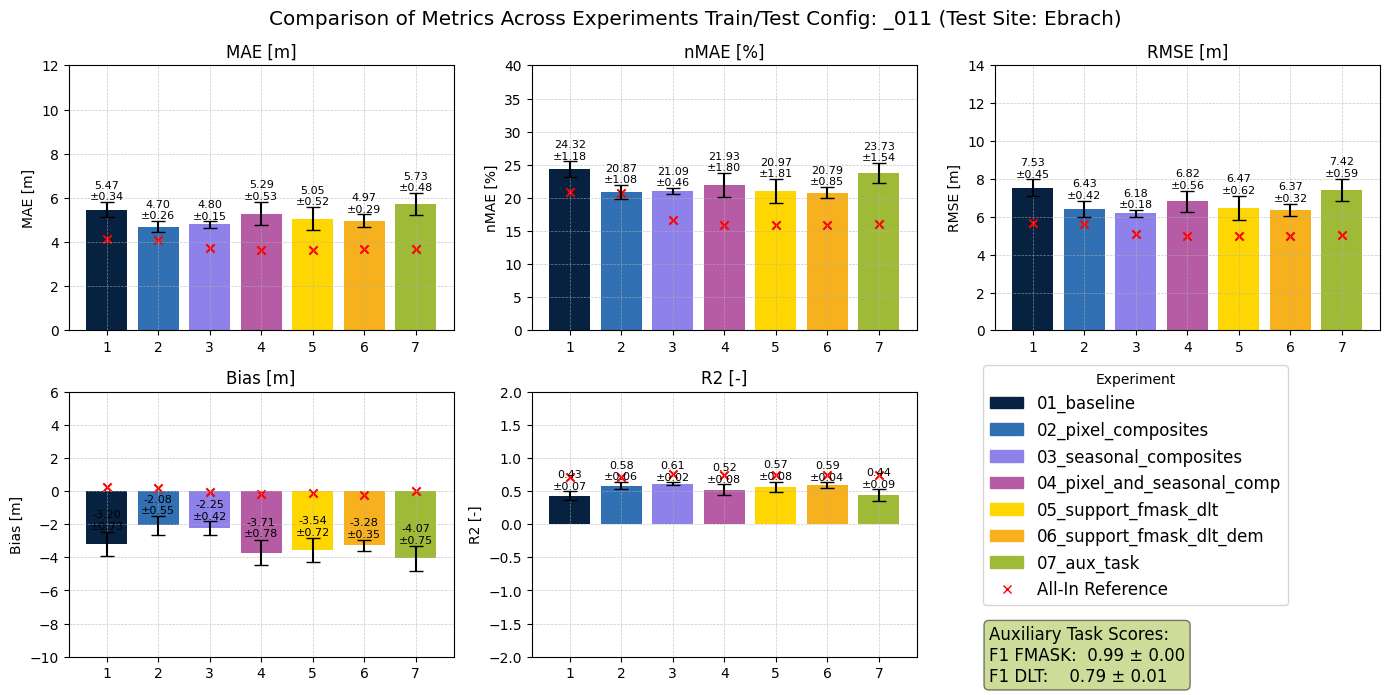

../results/gen/final/gscore/


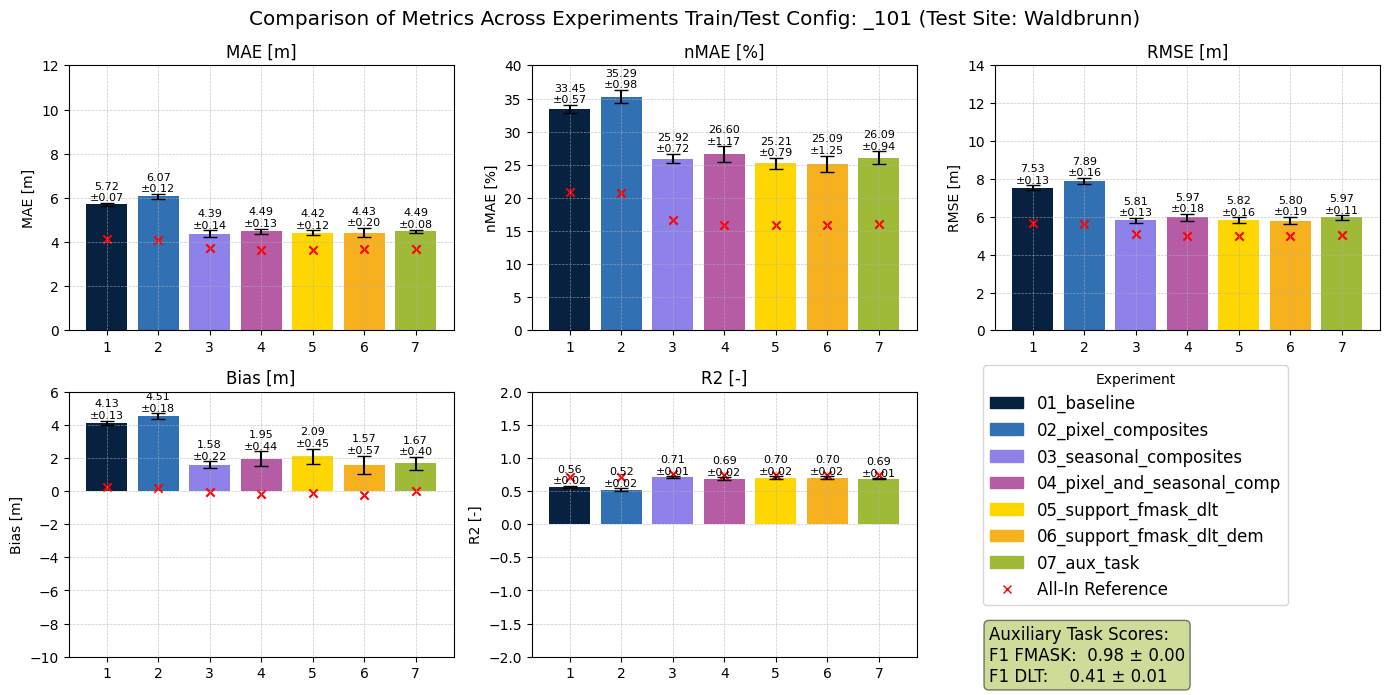

../results/gen/final/gscore/


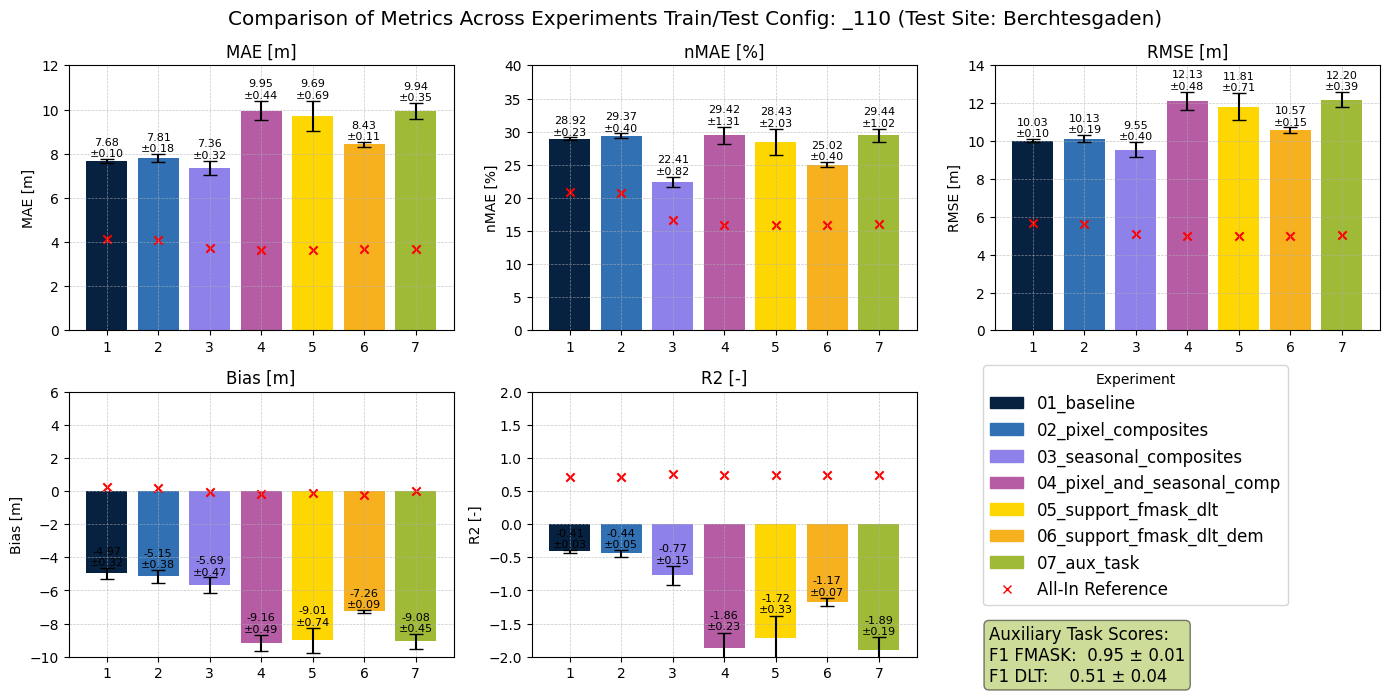

In [212]:
fig = eval.plot_comparison_all_gen(master_df, targetfolder="final",printout=True, savefig=True)

## other insights

### scatter overlays

In [220]:
run_id_base = "251021_GEN_"
# run_id_base = "251024_GEN2_"
# run_id_base = "251025_GEN_"
repetitions = 1
combos = ["110","101","011"] #1 is training data, 0 test.
run_ids = []
for i in range(repetitions): # Run 10 experiments with different seeds
    for combo in combos:
        #run_id = md.generate_run_id()
        run_id = run_id_base + f"_{combo}_{i}"
        run_ids.append(run_id)

run_ids.append("251024_FINAL_0") # add one all_in ref


In [222]:
dfall = pd.DataFrame()  # cols: experiment, preds, targets, run_id
dfpatch = pd.DataFrame() #keeps the patch structure.

# SELECT EXPERIMENTAL CONFIG
for run_id in tqdm(run_ids):
    with open('../configs/experiments.yaml', 'r') as f:
        experiments = yaml.safe_load(f)
        # experiment_names = list(experiments.keys())
        #run_id = "251009_4" #"250929_02" #"250930_1"
        exp_dir = os.path.join("..", "results", run_id, "train")
        experiment_names = sorted(
            [name for name in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, name))]
        )
        #experiment_names = experiment_names[6:7]  # Select the first 7 experiment names
        print("Available experiments:", experiment_names)

    # Prepare lists to collect all predictions, targets, and experiment names across all runs
    if 'all_preds' not in locals():
        all_preds = []
        all_targets = []
        all_exp_names = []
        all_run_ids = []

    for exp_name in experiment_names:
        sites, cfg = cf.get_config(exp_name)
        #global_config = md.global_config
        model_weights, logs, cfg = md.load_results(exp_name, run_id)
        if run_id == "251024_FINAL_0":
            cfg['combo'] = "111"
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = [None] * 7
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = md.load_np_stacks(exp_name, run_id)
        # Take only the first channel [:,0,:,:], flatten, and drop masked values
        preds_flat = preds_test[:, 0, :, :].reshape(-1)
        targets_flat = targets_test[:, 0, :, :].reshape(-1)
        mask_flat = masktest[:, 0, :, :].reshape(-1).astype(bool)
        # Keep only unmasked values (mask==1)
        valid_idx = mask_flat
        preds_valid = preds_flat[valid_idx]
        targets_valid = targets_flat[valid_idx]

        # Append to dfall DataFrame with current exp_name and run_id
        df_tmp = pd.DataFrame({
            "experiment": exp_name,
            "run_id": run_id,
            "combo": cfg['combo'],
            "preds": preds_valid,
            "targets": targets_valid, 
            'seed': cfg['seed']
        })
        dfall = pd.concat([dfall, df_tmp], ignore_index=True)

  0%|          | 0/4 [00:00<?, ?it/s]

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 25%|██▌       | 1/4 [00:00<00:01,  2.19it/s]

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 50%|█████     | 2/4 [00:01<00:01,  1.56it/s]

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 75%|███████▌  | 3/4 [00:02<00:00,  1.16it/s]

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


In [223]:
cfg['combo']

'111'

In [217]:
dfall["combo"].unique()

array(['110', '101', '011'], dtype=object)

/var/folders/0s/1cgzkm553c3gm9c4dkbzdh680000gn/T/ipykernel_23625/4225176848.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1])


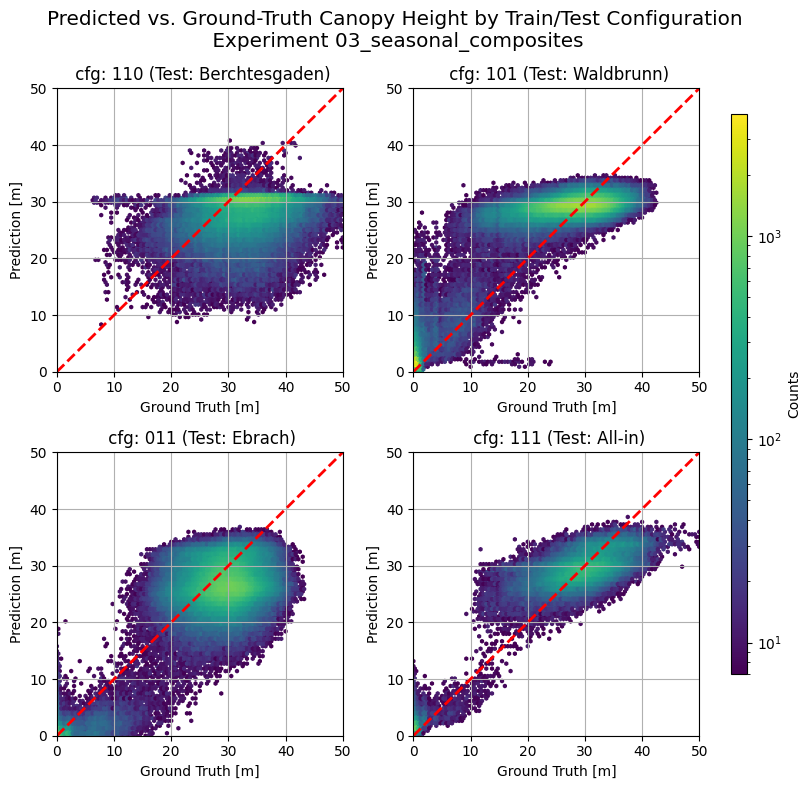

In [235]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter for the one experiment
exp_name = "03_seasonal_composites" 
#exp_name = "07_aux_task"
dfall_ = dfall[dfall["experiment"] == exp_name]

combodict = {
    "011": "Ebrach",
    "101": "Waldbrunn",
    "110": "Berchtesgaden",
    "111": "All-in"
}

combos = dfall_["combo"].unique()
n_combo = len(combos)
ncols = min(2, n_combo)
nrows = (n_combo + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), squeeze=False)

# Find global min and max counts across all combos for consistent color scale
global_vmin, global_vmax = 7, 0
for combo in combos:
    sub = dfall_[dfall_['combo'] == combo]
    hb_temp = axes[0, 0].hexbin(
        sub['targets'], sub['preds'],
        gridsize=100, extent=(0, 50, 0, 50), mincnt=global_vmin
    )
    counts = hb_temp.get_array()
    if len(counts) > 0:
        global_vmin = min(global_vmin, counts.min())
        global_vmax = max(global_vmax, counts.max())
    hb_temp.remove()

global_vmin = max(global_vmin, 1)  # Avoid log(0)

for idx, combo in enumerate(combos):
    ax = axes[idx // ncols, idx % ncols]
    sub = dfall_[dfall_['combo'] == combo]
    hb = ax.hexbin(
        sub['targets'], sub['preds'],
        gridsize=100, cmap='viridis', bins='log', extent=(0, 50, 0, 50),
        mincnt=global_vmin, vmin=global_vmin, vmax=global_vmax
    )
    ax.plot([0, 50], [0, 50], color='red', linestyle='--', linewidth=2, label='Ideal')
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 50)
    #ax.set_title(f"Combo: {combo}")
    ax.set_title( (f' cfg: {combo} (Test: {combodict[combo]})'), fontsize='large')

    ax.set_xlabel('Ground Truth [m]')
    ax.set_ylabel('Prediction [m]')
    ax.grid(True)

# Add single shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.matplotlib.colors.LogNorm(vmin=global_vmin, vmax=global_vmax))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Counts')

plt.suptitle(f"Predicted vs. Ground-Truth Canopy Height by Train/Test Configuration\n Experiment {exp_name}", fontsize='x-large')

# Hide any unused subplots
for i in range(n_combo, nrows * ncols):
    axes[i // ncols, i % ncols].axis('off')

plt.tight_layout(rect=[0, 0, 0.91, 1])
path = "../results/gen/final/metrics/scatter_density_gen_bycombo.png"
fig.savefig(path)
plt.show()


### experimental dimensions etc

In [5]:
def plot_experiment_matrix(experiments, order_exps=None, figsize=(14, 6), cmap="Greens"):
  """
  Visualize experiment configs as a binary/config matrix.
  Rows = experiments (index), Columns = features:
    - spectral seasons (prefixed 'season:')
    - spectral quantiles (prefixed 'quantile:')
    - aux inputs (prefixed 'aux:')
    - outputs (prefixed 'out:'; annotated with loss/weight when available)
    - strategy (prefixed 'strategy:')
  A colored cell indicates presence; annotation shows 'x' for simple presence
  or for outputs shows "<loss>|w=<weight>" if available.

  Args:
    experiments (dict): mapping experiment_name -> config dict
    order_exps (list, optional): list of experiment names to control row order
    figsize (tuple): matplotlib figure size
    cmap (str): colormap for seaborn.heatmap
  Returns:
    pd.DataFrame: binary presence matrix (0/1)
  """
  # collect experiment names
  exp_names = list(experiments.keys()) if order_exps is None else order_exps
  # gather all possible columns
  seasons = set()
  quantiles = set()
  aux_inputs = set()
  outputs = set()
  strategies = set()

  for name in exp_names:
    cfg = experiments.get(name, {})
    spec = cfg.get("spectral", {}) or {}
    s = spec.get("seasons", []) or []
    q = spec.get("quantiles", []) or []
    for si in s: seasons.add(si)
    for qi in q: quantiles.add(qi)
    for ai in (cfg.get("aux_inputs") or []): aux_inputs.add(ai)
    for out_name in (cfg.get("outputs") or {}).keys(): outputs.add(out_name)
    strategies.add(cfg.get("strategy", "None"))

  # build ordered column list
  col_list = []
  # strategy columns (one-hot)
  strat_cols = [f"strategy:{s}" for s in sorted(strategies)]
  col_list.extend(strat_cols)
  # spectral
  season_cols = [f"season:{s}" for s in sorted(seasons)]
  quantile_cols = [f"quantile:{q}" for q in sorted(quantiles)]
  col_list.extend(season_cols)
  col_list.extend(quantile_cols)
  # aux inputs
  aux_cols = [f"aux:{a}" for a in sorted(aux_inputs)]
  col_list.extend(aux_cols)
  # outputs
  out_cols = [f"out:{o}" for o in sorted(outputs)]
  col_list.extend(out_cols)

  # prepare matrices
  mat = pd.DataFrame(0, index=exp_names, columns=col_list, dtype=int)
  annot = pd.DataFrame("", index=exp_names, columns=col_list)

  for name in exp_names:
    cfg = experiments.get(name, {}) or {}
    # strategy
    strat = cfg.get("strategy", None)
    if strat is not None:
      col = f"strategy:{strat}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "✔"
    # spectral
    spec = cfg.get("spectral", {}) or {}
    for s in spec.get("seasons", []) or []:
      col = f"season:{s}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "✔"
    for q in spec.get("quantiles", []) or []:
      col = f"quantile:{q}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "✔"
    # aux inputs
    for a in cfg.get("aux_inputs", []) or []:
      col = f"aux:{a}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "✔"
    # outputs: annotate with loss and weight if present
    for out_name, out_cfg in (cfg.get("outputs") or {}).items():
      col = f"out:{out_name}"
      if col in mat.columns:
        mat.at[name, col] = 1
        loss = out_cfg.get("loss")
        weight = out_cfg.get("weight")
        if loss is None and weight is None:
          annot.at[name, col] = "x"
        else:
          pieces = []
          if loss is not None:
            if loss == "crossentropy":
              loss = "ce"
            pieces.append(str(loss))
          # if weight is not None:
          #   pieces.append(f"w={weight}")
          annot.at[name, col] = "|".join(pieces)

  # Plot with seaborn heatmap and string annotations
  import seaborn as sns  # seaborn is available in notebook; import again is harmless
  plt.figure(figsize=figsize)
  ax = sns.heatmap(mat, cmap=cmap, cbar=False, linewidths=0.5, linecolor="#dddddd",
       annot=annot.values, fmt="", annot_kws={"fontsize": 12}, vmin=0, vmax=3)
  ax.set_ylabel("")  # experiments are rows already
  ax.set_xlabel("")  # columns explain themselves
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

  # Add bold vertical lines
  strategy_end = len(strat_cols)
  inputs_end = strategy_end + len(season_cols) + len(quantile_cols) + len(aux_cols)
  ax.axvline(x=strategy_end, color="black", linewidth=2)  # Line after strategy
  ax.axvline(x=inputs_end, color="black", linewidth=2)    # Line after all inputs
  ax.axhline(y=1, color="black", linewidth=2) 
  ax.axhline(y=4, color="black", linewidth=2) 
  ax.axhline(y=6, color="black", linewidth=2) 



  plt.title("Experiment configuration mapping")
  plt.tight_layout()
  plt.show()

  return mat

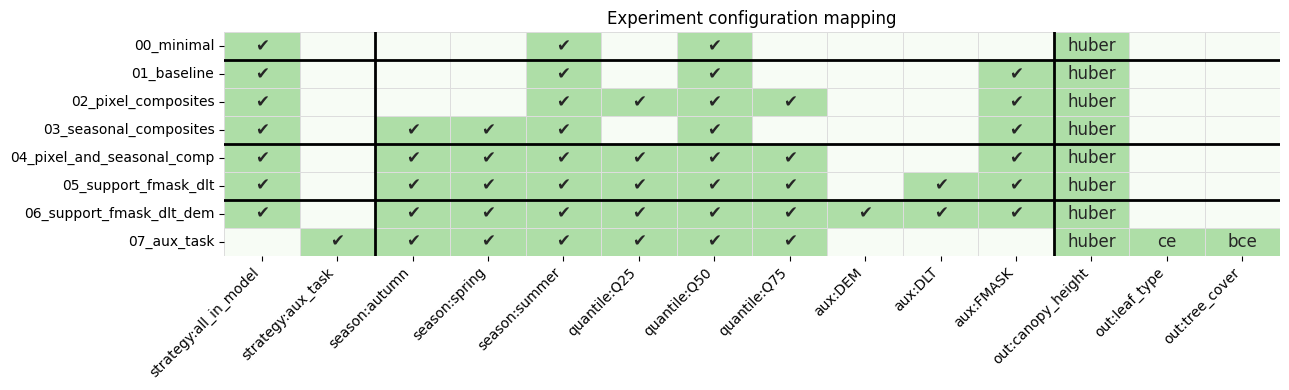

,strategy:all_in_model,strategy:aux_task,season:autumn,season:spring,season:summer,quantile:Q25,quantile:Q50,quantile:Q75,aux:DEM,aux:DLT,aux:FMASK,out:canopy_height,out:leaf_type,out:tree_cover
00_minimal,1,0,0,0,1,0,1,0,0,0,0,1,0,0
01_baseline,1,0,0,0,1,0,1,0,0,0,1,1,0,0
02_pixel_composites,1,0,0,0,1,1,1,1,0,0,1,1,0,0
03_seasonal_composites,1,0,1,1,1,0,1,0,0,0,1,1,0,0
04_pixel_and_seasonal_comp,1,0,1,1,1,1,1,1,0,0,1,1,0,0
05_support_fmask_dlt,1,0,1,1,1,1,1,1,0,1,1,1,0,0
06_support_fmask_dlt_dem,1,0,1,1,1,1,1,1,1,1,1,1,0,0
07_aux_task,0,1,1,1,1,1,1,1,0,0,0,1,1,1


In [6]:
plot_experiment_matrix(experiments, figsize=(13, 4), cmap="Greens")

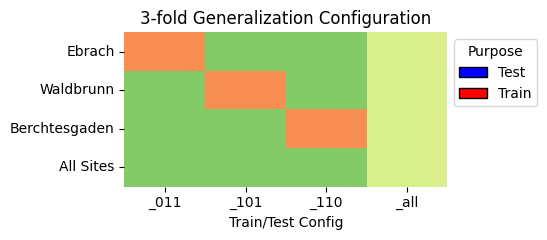

In [236]:
combodict = {
        "_011": "Ebrach",
        "_101": "Waldbrunn",
        "_110": "Berchtesgaden",
        "_all": "All Sites"
    }

# do a little matrix visualization, rows = Sitenames, taken from combodict, columns is the key of combodict, titled Train/Test Config. the Dataset with 0 is test set, 1 is train. illustrate the generalization setup.
import seaborn as sns
import matplotlib.pyplot as plt
data = []
for combo, sitename in combodict.items():
    row = []
    for key in combodict.keys():
        if combo == key:
            row.append(0.0)
        else:
            row.append(1.0)
    data.append(row)

#append one extra row for "_all" with all 1s
#data.append([1.0]*len(combodict))
#combodict["_all"] = "All Sites"
# do a little matrix visualization, rows = Sitenames, taken from combodict, columns is the key of combodict, titled Train/Test Config. 
# The Dataset with 0 is test set, 1 is train. Illustrate the generalization setup.

#set the col _all to 0.7 for all rows 
for i in range(len(data)):
    data[i][3]= 0.7

# Create a heatmap
plt.figure(figsize=(6, 2.5))
ax = sns.heatmap(data, annot=False, fmt="f", cmap="RdYlGn", vmin=-0.5, vmax=1.5, cbar=False, xticklabels=combodict.keys(), yticklabels=combodict.values())

# Add labels and title
ax.set_xlabel("Train/Test Config")
ax.set_ylabel("")
ax.set_title("3-fold Generalization Configuration")

# Add a legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', edgecolor='black', label='Test'),
                   Patch(facecolor='red', edgecolor='black', label='Train')]
plt.legend(handles=legend_elements, loc='upper right', title="Purpose", bbox_to_anchor=(1.3, 1))
plt.grid(False)
plt.tight_layout()
plt.show()

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


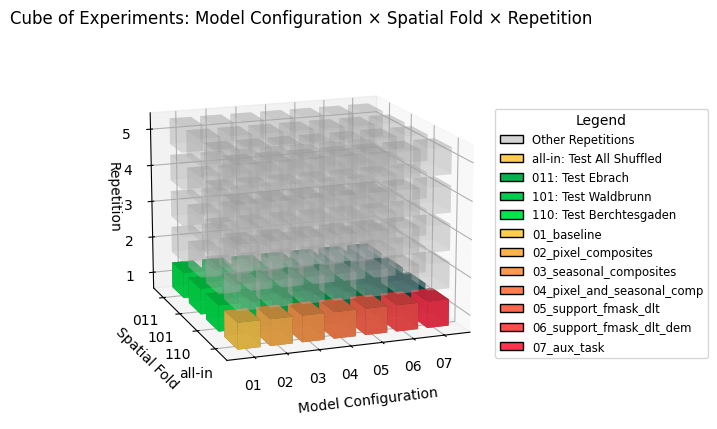

In [23]:
import numpy as np
import matplotlib.pyplot as plt

x_labels = [f"0{i+1}" for i in range(7)]
y_labels = ["all-in","110", "101", "011"]
z_labels = [f"{i+1}" for i in range(5)]

with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[1:8]  # Select the first 7 experiment names
    print("Available experiments:", experiment_names)
    # Create a mapping from experiment names to their display names

combodict = {
        "all-in": "All Shuffled",
        "011": "Ebrach",
        "101": "Waldbrunn",
        "110": "Berchtesgaden"
    }

fig = plt.figure(figsize=(5, 6))
ax = fig.add_subplot(111, projection='3d')

_x = np.arange(len(x_labels))
_y = np.arange(len(y_labels))
_z = np.arange(len(z_labels))

dx = dy = dz = 0.7  # box size

for xi in _x:
    for yi in _y:
        for zi in _z:
            if zi == 0:  # Only Rep1
                if yi == 0:  # all-in fold
                    color = (1.0, 0.8 - 0.1*xi, 0.3)
                else:
                    color = (0.0, 0.9 - 0.1*xi, 0.3)
                ax.bar3d(xi, yi, zi, dx, dy, dz, color=color, alpha=0.9, shade=True)
            else:
                ax.bar3d(xi, yi, zi, dx, dy, dz, color='whitesmoke', alpha=0.25, shade=True)

ax.set_xticks(_x + dx/2)
ax.set_xticklabels(x_labels, rotation=0, ha='right')
ax.set_yticks(_y + dy/2)
ax.set_yticklabels(y_labels)
ax.set_zticks(_z + dz/2)
ax.set_zticklabels(z_labels)
ax.set_xlabel("\nModel Configuration")
ax.set_ylabel("Spatial Fold")
ax.set_zlabel("Repetition", labelpad=-2, ha='left', rotation=180)
ax.set_title("Cube of Experiments: Model Configuration × Spatial Fold × Repetition")
ax.view_init(azim=-110, elev=15)

# add a legend to the right, outside the plot
from matplotlib.patches import Patch

palette_combo = [(1.0, 0.8 - 0.1*i, 0.3) for i in range(len(x_labels))]

# Legend for spatial folds (y axis)
fold_colors = {
    "all-in": (1.0, 0.8, 0.3),
    "110": (0.0, 0.9, 0.3),
    "101": (0.0, 0.8, 0.3),
    "011": (0.0, 0.7, 0.3)
}
fold_patches = [
    Patch(facecolor=fold_colors[k], edgecolor='black', label=f"{k}: Test {v}") for k, v in combodict.items()
]

# Legend for experiment names (x axis)
exp_patches = [
    Patch(facecolor=palette_combo[i], edgecolor='black', label=f"{name}") for i, name in enumerate(experiment_names)
]

# Legend for repetitions (bars)
legend_elements = [
   # Patch(facecolor='olive', edgecolor='black', label='First Repetition'),
    Patch(facecolor='lightgrey', edgecolor='black', label='Other Repetitions')
]

# Place legends outside the plot
ax.legend(handles=legend_elements + fold_patches + exp_patches, 
          loc='upper left', bbox_to_anchor=(1.0, 0.8), borderaxespad=0., 
          title="Legend", fontsize='small')

#plt.tight_layout()
plt.grid(False)
plt.show()

path = "../results/gen/final/experiment_cube.pdf"
fig.savefig(path, bbox_inches='tight')


## convergence tester

Loss plot saved to ../results/all_in/final/plots/convergence_losses_aux_task.pdf


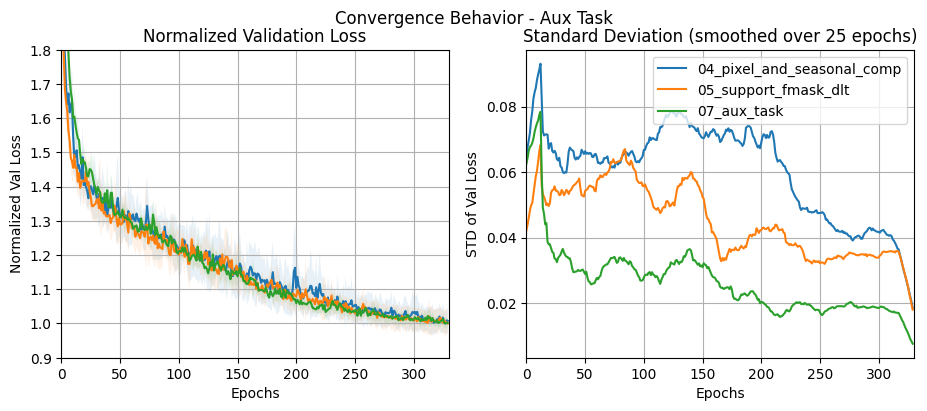

In [24]:
import json
import numpy as np

import matplotlib.pyplot as plt

# Constants
run_id_base = "251021_GEN_"
repetitions = 5
combos = ["110", "101", "011"]
run_ids = [f"{run_id_base}_{combo}_{i}" for i in range(repetitions) for combo in combos]
run_ids_allin = [f"251024_FINAL_{i}" for i in range(5)]
run_ids_allin = ["251102__" + str(i) for i in range(5)]
run_ids_allin = ["251102_ALLIN_" + str(i) for i in range(5)]
# Experiment names
experiment_names = ["04_pixel_and_seasonal_comp","05_support_fmask_dlt", "07_aux_task"] #05_support_fmask_dlt #04_pixel_and_seasonal_comp

# Path to read logs
path_base = "../results/{run_id}/train/{exp_name}/logs.json"

# Initialize dictionaries to store train and validation losses
losses = {exp: {"train": [], "val": []} for exp in experiment_names}

max_epochs = 330

# Read and aggregate losses
for exp_name in experiment_names:
    for run_id in run_ids_allin: #run_ids_allin, run_ids
        log_path = path_base.format(run_id=run_id, exp_name=exp_name)
        try:
            with open(log_path, 'r') as f:
                logs = json.load(f)
                losses[exp_name]["train"].append(logs.get("train_loss", [])[:max_epochs])
                losses[exp_name]["val"].append(logs.get("val_loss", [])[:max_epochs])
        except FileNotFoundError:
            print(f"Log file not found: {log_path}")

# Average and normalize losses
avg_losses = {exp: {"train": None, "val": None} for exp in experiment_names}
std_losses = {exp: {"train": None, "val": None} for exp in experiment_names}
normalized_losses = {exp: {"train": None, "val": None} for exp in experiment_names}

for exp_name in experiment_names:
    for loss_type in ["train", "val"]:
        if losses[exp_name][loss_type]:
            max_len = max(len(seq) for seq in losses[exp_name][loss_type])
            padded_losses = [np.pad(seq, (0, max_len - len(seq)), constant_values=np.nan) for seq in losses[exp_name][loss_type]]
            avg_losses[exp_name][loss_type] = np.nanmean(padded_losses, axis=0)
            #std_losses[exp_name][loss_type] = np.nanstd(padded_losses, axis=0)
            min_loss = np.nanmin(avg_losses[exp_name][loss_type])
            std_losses[exp_name][loss_type] = np.nanstd(padded_losses, axis=0) / min_loss
            normalized_losses[exp_name][loss_type] = avg_losses[exp_name][loss_type] / min_loss

# Plot loss curves
def plot_losses(losses, title, normalized=False, savefig=False, filepath="../results/all_in/final/plots/convergence_losses.png"):
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))  # Create subplots for loss and std
    ax_loss, ax_std = axes

    # Plot average loss
    for exp_name in experiment_names:
        if losses[exp_name]["val"] is not None:
            ax_loss.plot(losses[exp_name]["val"], label=f"{exp_name} - Val Loss", linestyle="-")
        if std_losses[exp_name]["val"] is not None:
            ax_loss.fill_between(
                np.arange(len(losses[exp_name]["val"])),
                losses[exp_name]["val"] - std_losses[exp_name]["val"],
                losses[exp_name]["val"] + std_losses[exp_name]["val"],
                alpha=0.1
            )
    ax_loss.set_xlabel("Epochs")
    if normalized:
        ax_loss.set_ylim(0.9, 1.8) 
    ax_loss.set_xlim(0, max_epochs)
    ax_loss.set_title("Normalized Validation Loss")
    ax_loss.set_ylabel("Normalized Val Loss")
    #ax_loss.legend()
    ax_loss.grid(True)

    # Plot standard deviation with smoothing
    for exp_name in experiment_names:
        if std_losses[exp_name]["val"] is not None:
            smoothed_std = np.convolve(std_losses[exp_name]["val"], np.ones(25)/25, mode='same')
            ax_std.plot(smoothed_std, label=f"{exp_name}", linestyle="-")
    ax_std.set_xlabel("Epochs")
    ax_std.set_ylabel("STD of Val Loss")
    #ax_std.set_ylim(0, 0.15)
    ax_std.set_xlim(0, max_epochs)
    ax_std.set_title("Standard Deviation (smoothed over 25 epochs)")
    ax_std.legend()
    ax_std.grid(True)

    plt.suptitle(title)

    if savefig:
        plt.savefig(filepath)
        print("Loss plot saved to", filepath)
    plt.show()


# Plot raw and normalized loss curves
#plot_losses(avg_losses, "Convergence Behaviour: Train vs. Validation Loss", "Loss")
plot_losses(normalized_losses, "Convergence Behavior - Aux Task", normalized=True, savefig=True, filepath="../results/all_in/final/plots/convergence_losses_aux_task.pdf")
